In this notebook, I'll fit and evaluate a simple one-layer KAN to the Delaney Aqueous Solubility dataset, and then investigate feature importance and the shape of activation functions.

In [1]:
# for imports
import sys
sys.path.append('../..')

# normal python data science stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm

# my utility functions
from utils.data_utils import get_all_descriptors_from_smiles_list

# KAN imports
from kan import KAN

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [2]:
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df_delaney = pd.read_csv(filepath)
df_delaney.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [3]:
# get list of smiles strings
smiles_list = list(df_delaney.SMILES)

# compute all molecular descriptors and store in pandas dataframe
descriptors_df = get_all_descriptors_from_smiles_list(smiles_list, as_dataframe=True)

100%|██████████| 1144/1144 [00:07<00:00, 145.31it/s]


In [4]:
descriptors_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,12.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,12.00,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,11.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,9.60,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,14.25,187.375,187.375,185.901768,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# extract X and y from dataframes
X = descriptors_df.copy()
y = df_delaney['measured log(solubility:mol/L)'].values

X.shape, y.shape

((1144, 210), (1144,))

In [6]:
# split data into training and testing sets
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(descriptors_df, y, test_size=test_size, random_state=1738)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((915, 210), (229, 210), (915,), (229,))

In [7]:
selector = VarianceThreshold(threshold = 1e-6)

X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

selector.get_feature_names_out()

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
       'SMR_VSA5'

In [8]:
# get the names of the features that were removed
removed_features = [name for name in selector.feature_names_in_ if name not in selector.get_feature_names_out()]
removed_features

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_Al_COO',
 'fr_Ar_COO',
 'fr_COO',
 'fr_COO2',
 'fr_amidine',
 'fr_azide',
 'fr_diazo',
 'fr_hdrzone',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_morpholine',
 'fr_nitroso',
 'fr_prisulfonamd',
 'fr_quatN',
 'fr_tetrazole',
 'fr_thiocyan']

In [9]:
# standardize features
scaler = StandardScaler()

# fit on training data only to avoid leakage
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [10]:
# convert to tensors
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [11]:
# make sure it's standardized correctly
assert torch.allclose(X_train_scaled.mean(axis=0), torch.zeros(X_train.shape[1]), atol=1e-6) \
and \
torch.allclose(X_train_scaled.std(axis=0), torch.ones(X_train.shape[1]), atol=0.01)

Text(0, 0.5, 'Standard Deviation')

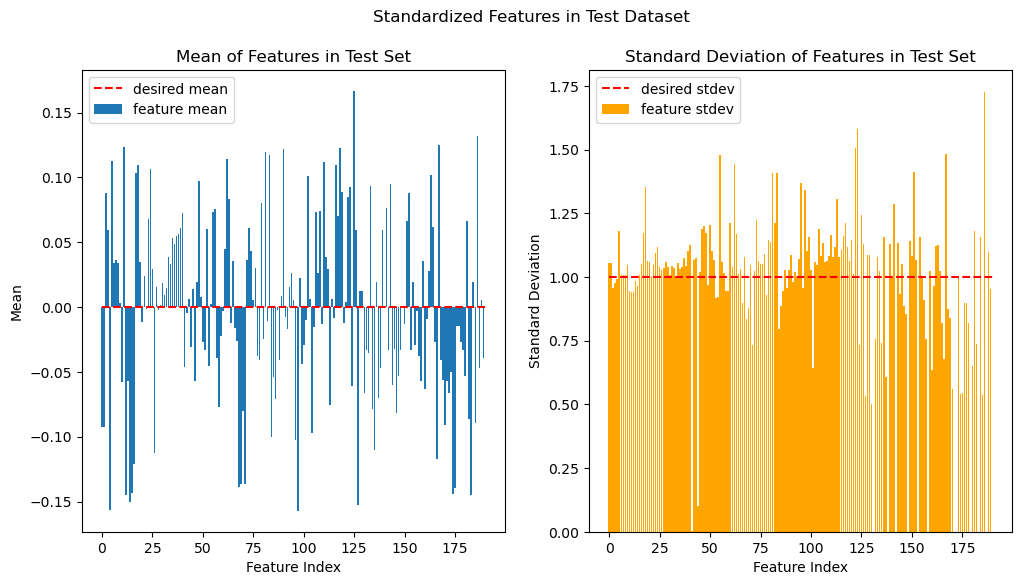

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

fig.suptitle('Standardized Features in Test Dataset')

# bar chart of means
ax[0].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.mean(axis=0))

ax[0].hlines(y=0, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[0].legend(['desired mean', 'feature mean'])

ax[0].set_title('Mean of Features in Test Set')

ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Mean')


# bar chart of standard deviations
ax[1].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.std(axis=0), color='orange')

ax[1].hlines(y=1, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[1].legend(['desired stdev', 'feature stdev'])  

ax[1].set_title('Standard Deviation of Features in Test Set')

ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Standard Deviation')

# Fitting One-layer KAN

In [13]:
num_features = X_train_scaled.shape[1]

torch.manual_seed(1738) 

model = KAN(width=[num_features, 1])

checkpoint directory created: ./model
saving model version 0.0


In [14]:
model

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [17]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses = torch.zeros(size=(num_itrs,))
test_mses = torch.zeros(size=(num_itrs,))

train_r2s = torch.zeros(size=(num_itrs,))
test_r2s = torch.zeros(size=(num_itrs,))

train_maes = torch.zeros(size=(num_itrs,))
test_maes = torch.zeros(size=(num_itrs,))

train_rmses = torch.zeros(size=(num_itrs,))
test_rmses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model(X_train_scaled)
    y_hat_train = y_hat_train[:, 0]

    train_mse = F.mse_loss(y_hat_train, y_train)
    train_mae = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse = torch.sqrt(train_mse.detach())
    train_r2 = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse.requires_grad and y_hat_train.requires_grad
    assert not train_mae.requires_grad and not train_rmse.requires_grad and not train_r2.requires_grad
    
    train_mse.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses[i] = train_mse.detach()
    train_maes[i] = train_mae
    train_rmses[i] = train_rmse
    train_r2s[i] = train_r2

    # test
    y_hat_test = model(X_test_scaled).detach()[:, 0]

    test_loss = F.mse_loss(y_hat_test, y_test)
    test_mae_loss = F.l1_loss(y_hat_test, y_test)
    test_rmse_loss = torch.sqrt(test_loss)
    test_r2 = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses[i] = test_loss
    test_maes[i] = test_mae_loss
    test_rmses[i] = test_rmse_loss
    test_r2s[i] = test_r2

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse.item()}, r2: {train_r2.item()}, mae: {train_mae.item()}, rmse: {train_rmse.item()}')
        print(f'test iteration {i}, mse: {test_loss.item()}, r2: {test_r2.item()}, mae: {test_mae_loss.item()}, rmse: {test_rmse_loss.item()}')

train iteration 0, mse: 12.819317817687988, r2: -1.9847564697265625, mae: 2.968919515609741, rmse: 3.5804073810577393
test iteration 0, mse: 4.815492153167725, r2: -0.008392572402954102, mae: 1.7053226232528687, rmse: 2.194422960281372
train iteration 50, mse: 0.39253389835357666, r2: 0.9086052775382996, mae: 0.481263667345047, rmse: 0.6265252828598022
test iteration 50, mse: 0.5355684161186218, r2: 0.8878487944602966, mae: 0.5686448812484741, rmse: 0.7318254113197327
train iteration 100, mse: 0.2714374363422394, r2: 0.936800479888916, mae: 0.3969889283180237, rmse: 0.5209965705871582
test iteration 100, mse: 0.4840121269226074, r2: 0.8986449837684631, mae: 0.5381720066070557, rmse: 0.6957098245620728
train iteration 150, mse: 0.22482430934906006, r2: 0.9476535320281982, mae: 0.362619012594223, rmse: 0.4741564095020294
test iteration 150, mse: 0.4662758409976959, r2: 0.9023590683937073, mae: 0.5221133828163147, rmse: 0.6828439235687256
train iteration 200, mse: 0.1949346363544464, r2: 

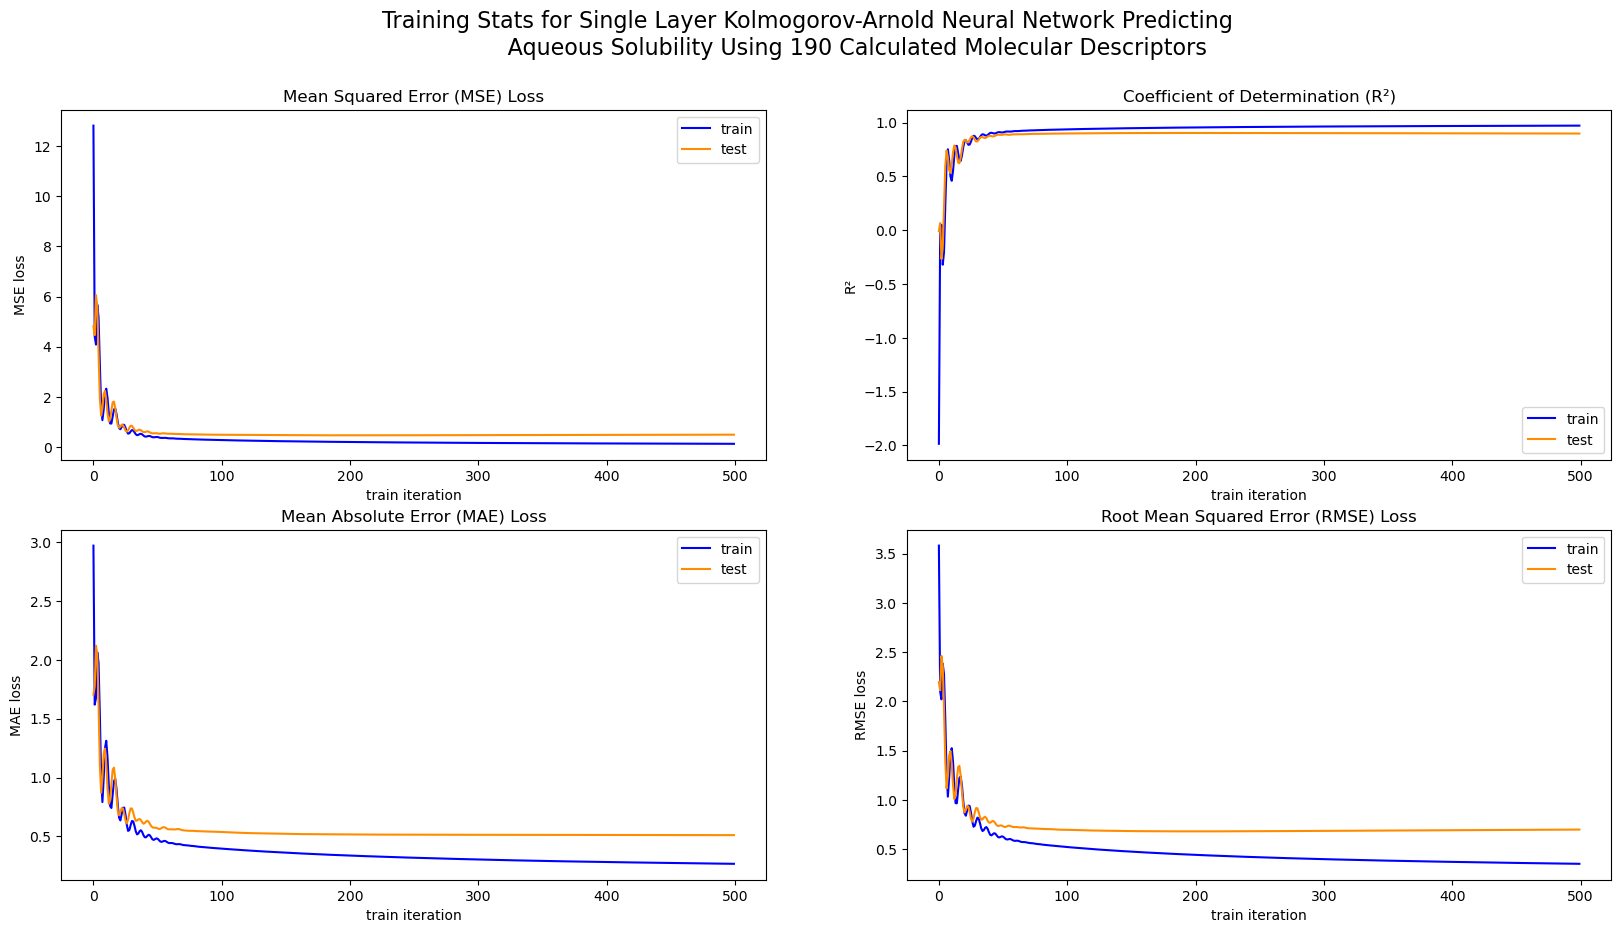

In [18]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting 
             Aqueous Solubility Using {X_train_scaled.shape[1]} Calculated Molecular Descriptors''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train', 'test'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train', 'test'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train', 'test'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train', 'test'])

# Investigating Activations

In [58]:
# I'm going to do this for the full dataset for now
X_scaled = torch.concat((X_train_scaled, X_test_scaled), axis=0)
X_scaled.shape

torch.Size([1144, 190])

In [63]:
model(X_scaled)

tensor([[-2.7297],
        [-4.8245],
        [-2.3661],
        ...,
        [-4.5367],
        [-0.2958],
        [-4.5129]], grad_fn=<AddBackward0>)

In [64]:
# making sure I'm accessing the activations correctly
assert torch.allclose(model.spline_postacts[0][:, 0, :].sum(axis=1).unsqueeze(dim=1), model(X_scaled))
# the sum of the activations should be equal to the output of the model

In [67]:
# get the activations
activations = model.spline_postacts[0][:, 0, :]
assert activations.shape == X_scaled.shape, 'shape of activations should match shape of input data for one-layer KAN (num_samples, num_features)'
activations.shape # should be (num_samples, num_features)

torch.Size([1144, 190])

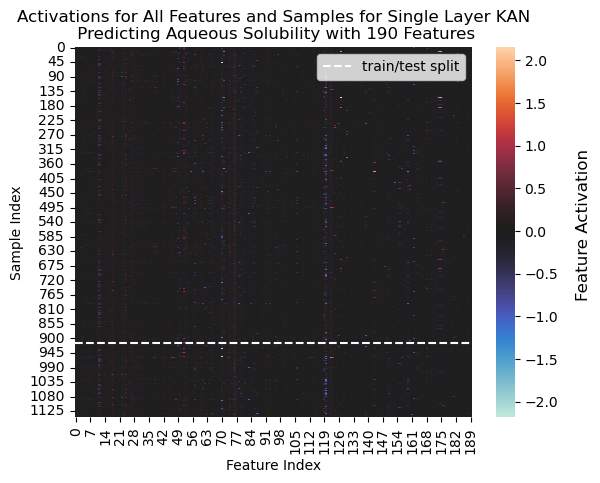

In [180]:
# visualizing all activations for all training samples
sns.heatmap(activations, cmap=None, center=0)
plt.title(f'Activations for All Features and Samples for Single Layer KAN\n Predicting Aqueous Solubility with {X_scaled.shape[1]} Features')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')

plt.text(x=240, y=775, s='Feature Activation', color='black', rotation='vertical', fontsize=12)

plt.axhline(y=X_train_scaled.shape[0], xmin=0, xmax=X_scaled.shape[1], color='white', linestyle='dashed')
plt.legend(['train/test split'])
plt.show()

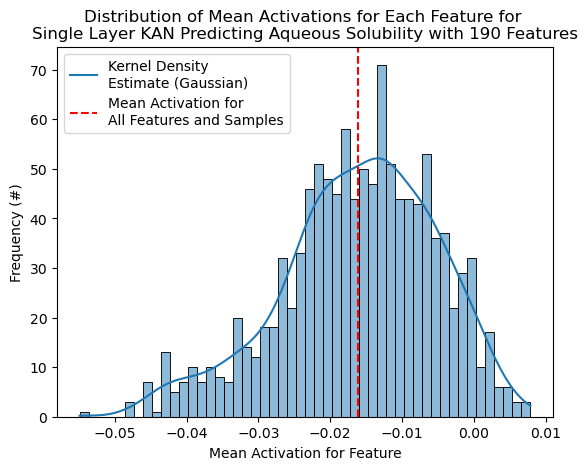

In [150]:
mean_activations = activations.mean(axis=1)
sns.histplot(mean_activations, bins=50, kde=True)
plt.title(f'Distribution of Mean Activations for Each Feature for \nSingle Layer KAN Predicting Aqueous Solubility with {X_scaled.shape[1]} Features')
plt.xlabel('Mean Activation for Feature')
plt.ylabel('Frequency (#)')

plt.axvline(x=activations.mean(), color='r', linestyle='dashed')

plt.legend(['Kernel Density \nEstimate (Gaussian)', 'Mean Activation for \nAll Features and Samples'])

plt.show()

# Feature Selection Using Activations

In [148]:
# get activations for training data
y_hat_train = model(X_train_scaled).detach()
activations_train = model.spline_postacts[0][:, 0, :]
assert activations_train.shape == X_train_scaled.shape, 'shape of activations should match shape of input data for one-layer KAN (num_samples, num_features)'
assert torch.allclose(activations_train.sum(axis=1).unsqueeze(axis=1), y_hat_train), 'sum of activations should be equal to output of model'

In [139]:
# getting the feature names post initial variance selection so I can keep track of what I remove
features_after_variance_selection = selector.get_feature_names_out()
assert len(features_after_variance_selection) == X_train_scaled.shape[1] == activations_train.shape[1], \
'number of features should match number of features in training data and activations'

In [191]:
activations_train_feature_means = activations_train.mean(axis=0)
assert activations_train_feature_means.sum() == y_hat_train.mean()
activations_train_feature_means.shape

torch.Size([190])

In [193]:
activations_train_feature_means.std()

tensor(0.0285)

idea: automate the training loop and experiment with different thresholds for feature selection, then plot all together and compare